# Potato Leaf Dataset Pakistan

## Transfer Learning models (VGG19, GoogLeNet, ResNet50)

Inspiration taken from: https://www.kaggle.com/code/sakthimurugavel/potato-leaf-disease-classifier-review-ii-final/notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import all the required dependencies

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.utils import plot_model

### Define the constants

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3
EPOCHS = 50 

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/Dissertation/Code/PLD_larger_dataset"

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(path, 
                                                              shuffle = True, 
                                                              image_size = (IMAGE_SIZE, IMAGE_SIZE), 
                                                              batch_size = BATCH_SIZE
)

Found 4072 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names # 0 = early blight, 1 = late blight, 2 = healthy

['Potato_Early_blight', 'Potato_Late_blight', 'Potato_healthy']

In [ ]:
def DatasetSize(path):
    number_of_images = {} #tuple
    for folder in os.listdir(path):
        number_of_images[folder] = len(os.listdir(os.path.join(path, folder)))
    return number_of_images

data_set = DatasetSize(path) #??
print(data_set)

{'Potato_Early_blight': 1628, 'Potato_healthy': 1020, 'Potato_Late_blight': 1424}


In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[1 2 0 1 0 0 0 0 2 0 1 2 0 0 2 1 0 0 1 1 2 1 2 0 2 0 1 2 1 2 0 1]


### Visualise the images

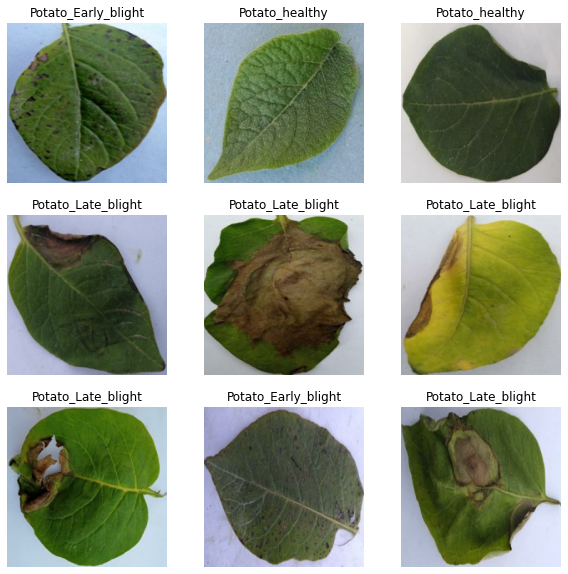

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Split the dataset

In [ ]:
# Use split folders
#splitfolders --ratio .8 .1 .1 -- 

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
splitfolders.ratio(path, output="/content/drive/MyDrive/Colab Notebooks/Dissertation/Code/TransferLearning/outputlarge", seed=1337, ratio=(0.8, 0.1,0.1))

Copying files: 4072 files [00:38, 106.94 files/s]


### Data Preprocessing and Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 10,
        horizontal_flip = True
)

train_generator = train_datagen.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/Dissertation/Code/TransferLearning/outputlarge/train",
                                                   target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                   batch_size = 32,
                                                   class_mode = "sparse")

Found 3257 images belonging to 3 classes.


In [ ]:
train_generator.class_indices

{'Potato_Early_blight': 0, 'Potato_Late_blight': 1, 'Potato_healthy': 2}

In [ ]:
class_names = list(train_generator.class_indices.keys())
class_names

['Potato_Early_blight', 'Potato_Late_blight', 'Potato_healthy']

In [ ]:
# Validation 

validation_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 10,
        horizontal_flip = True
)

validation_generator = validation_datagen.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/Dissertation/Code/TransferLearning/outputlarge/val",
                                                   target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                   batch_size = 32,
                                                   class_mode = "sparse")


Found 406 images belonging to 3 classes.


In [ ]:
# Test

test_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 10,
        horizontal_flip = True
)

test_generator = test_datagen.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/Dissertation/Code/TransferLearning/outputlarge/test",
                                                   target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                   batch_size = 32,
                                                   class_mode = "sparse")


Found 409 images belonging to 3 classes.


### VGG19

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

def create_model():
    model = models.Sequential()
    model.add(VGG19(include_top = False, weights = 'imagenet', input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation = 'relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(n_classes, activation='softmax'))
    
    return model

In [ ]:
vgg19_with_aug_model = create_model()
vgg19_with_aug_model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 77

### Compiling the model and determining the accuracy

In [ ]:
vgg19_with_aug_model.compile(
                            optimizer= 'adam',
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                            metrics=['accuracy'])

In [ ]:
vgg19_with_aug_history = vgg19_with_aug_model.fit(
    train_generator,
    steps_per_epoch=54,
    batch_size=32,
    validation_data=validation_generator,
    validation_steps=7,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
54/54 [==============================] - 33s 591ms/step - loss: 1.0798 - accuracy: 0.3998 - val_loss: 1.0772 - val_accuracy: 0.4152
Epoch 2/50
54/54 [==============================] - 31s 577ms/step - loss: 1.0763 - accuracy: 0.4143 - val_loss: 1.0821 - val_accuracy: 0.3795
Epoch 3/50
54/54 [==============================] - 32s 586ms/step - loss: 1.0790 - accuracy: 0.4062 - val_loss: 1.0813 - val_accuracy: 0.4196
Epoch 4/50
54/54 [==============================] - 32s 580ms/step - loss: 1.0799 - accuracy: 0.4073 - val_loss: 1.0887 - val_accuracy: 0.4018
Epoch 5/50
54/54 [==============================] - 32s 592ms/step - loss: 1.0821 - accuracy: 0.3957 - val_loss: 1.0761 - val_accuracy: 0.4196
Epoch 6/50
54/54 [==============================] - 32s 581ms/step - loss: 1.0835 - accuracy: 0.3974 - val_loss: 1.0952 - val_accuracy: 0.3438
Epoch 7/50
54/54 [==============================] - 32s 596ms/step - loss: 1.0722 - accuracy: 0.4079 - val_loss: 1.0634 - val_accuracy: 0.4464

### Producing the test accuracy and test loss

In [ ]:
vgg19_with_aug_scores = vgg19_with_aug_model.evaluate(test_generator)
vgg19_with_aug_test_acc = vgg19_with_aug_scores[1]*100
vgg19_with_aug_test_loss = vgg19_with_aug_scores[0]
print("Test Loss: ", vgg19_with_aug_test_loss) 
print("Test Accuracy: ", vgg19_with_aug_test_acc) 

13/13 [==============================] - 6s 416ms/step - loss: 1.0803 - accuracy: 0.4010
Test Loss:  1.080260157585144
Test Accuracy:  40.09779989719391


### VGG19 plot for accuracy vs loss 

In [ ]:
vgg19_with_aug_history

In [ ]:
vgg19_with_aug_acc = vgg19_with_aug_history.history['accuracy']
vgg19_with_aug_val_acc = vgg19_with_aug_history.history['val_accuracy']

vgg19_with_aug_loss = vgg19_with_aug_history.history['loss']
vgg19_with_aug_val_loss = vgg19_with_aug_history.history['val_loss']

n = range(1, EPOCHS+1)

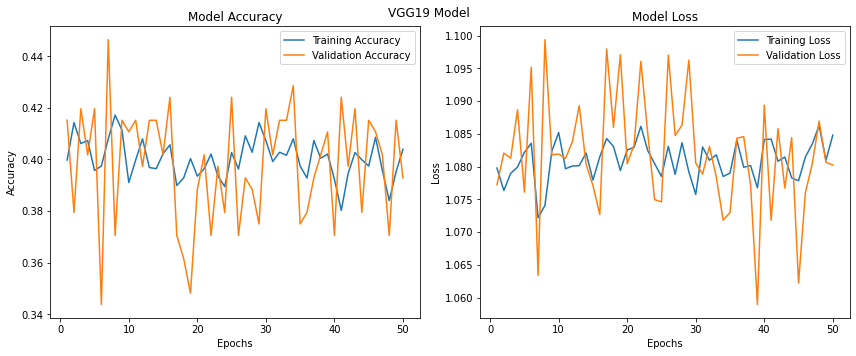

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(n, vgg19_with_aug_acc, label='Training Accuracy')
plt.plot(n, vgg19_with_aug_val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1,2,2)
plt.plot(n, vgg19_with_aug_loss, label='Training Loss')
plt.plot(n, vgg19_with_aug_val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.tight_layout()
plt.suptitle('VGG19 Model')
plt.savefig("plot_vgg19.png")
plt.show()

### Prediction of images using VGG19

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 15ms/step


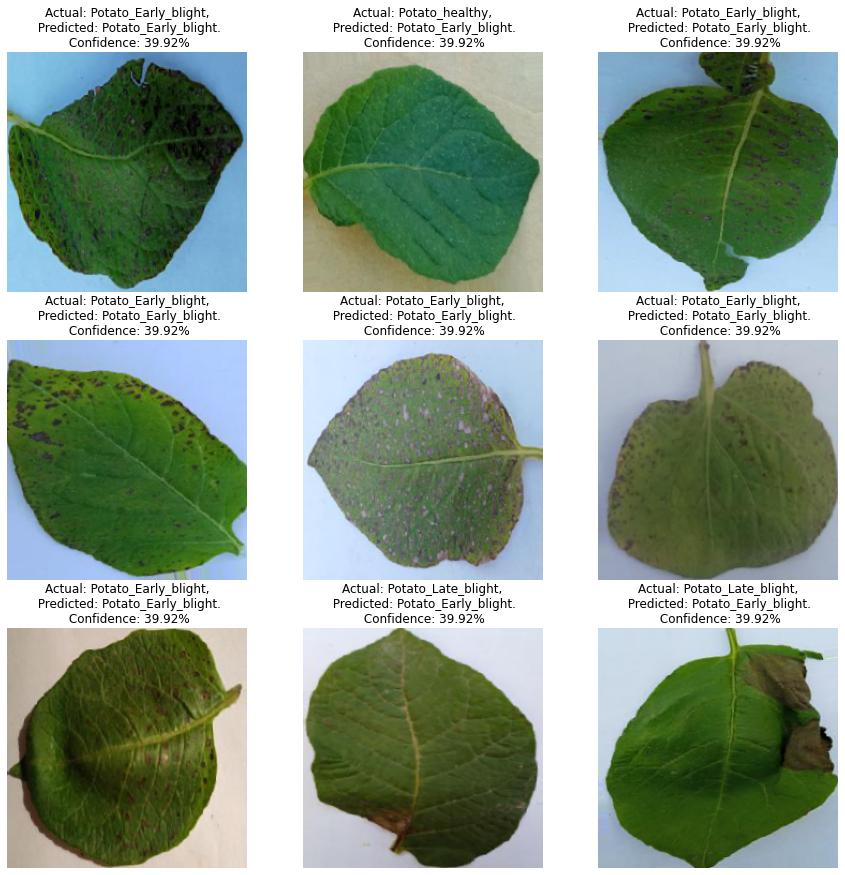

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(vgg19_with_aug_model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

plt.savefig("VGG19_prediction images")
plt.show()

### GoogLeNet (InceptionV3)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

def create_model():
    model = models.Sequential()
    model.add(VGG19(include_top = False, weights = 'imagenet', input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation = 'relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(n_classes, activation='softmax'))
    
    return model

In [ ]:
inceptionv3_with_aug_model = create_model()
inceptionv3_with_aug_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 771       
                                                      

### Compiling the model and determining the accuracy

In [ ]:
inceptionv3_with_aug_model.compile(
                            optimizer='adam',
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                            metrics=['accuracy'])

In [ ]:
inceptionv3_with_aug_history = inceptionv3_with_aug_model.fit(train_generator,
                                                   steps_per_epoch=54,
                                                   batch_size=32,
                                                   validation_data=validation_generator,
                                                    validation_steps = 7,
                                                    verbose=1,
                                                    epochs=EPOCHS)

Epoch 1/50
54/54 [==============================] - 35s 624ms/step - loss: 1.5829 - accuracy: 0.3847 - val_loss: 1.0872 - val_accuracy: 0.3884
Epoch 2/50
54/54 [==============================] - 31s 576ms/step - loss: 1.0894 - accuracy: 0.3715 - val_loss: 1.0824 - val_accuracy: 0.4018
Epoch 3/50
54/54 [==============================] - 32s 577ms/step - loss: 1.0920 - accuracy: 0.3951 - val_loss: 1.0758 - val_accuracy: 0.4241
Epoch 4/50
54/54 [==============================] - 33s 611ms/step - loss: 1.0848 - accuracy: 0.3916 - val_loss: 1.0816 - val_accuracy: 0.4062
Epoch 5/50
54/54 [==============================] - 32s 583ms/step - loss: 1.0840 - accuracy: 0.3916 - val_loss: 1.0808 - val_accuracy: 0.4018
Epoch 6/50
54/54 [==============================] - 32s 578ms/step - loss: 1.0824 - accuracy: 0.4034 - val_loss: 1.0853 - val_accuracy: 0.3839
Epoch 7/50
54/54 [==============================] - 32s 578ms/step - loss: 1.0800 - accuracy: 0.4120 - val_loss: 1.0865 - val_accuracy: 0.3973

### Producing the test accuracy and test loss

In [ ]:
inceptionv3_with_aug_scores = inceptionv3_with_aug_model.evaluate(test_generator)
inceptionv3_with_aug_test_acc = inceptionv3_with_aug_scores[1]*100
inceptionv3_with_aug_test_loss = inceptionv3_with_aug_scores[0]
print("Test Loss: ", inceptionv3_with_aug_test_loss)
print("Test Accuracy: ", inceptionv3_with_aug_test_acc) 

13/13 [==============================] - 6s 427ms/step - loss: 1.0803 - accuracy: 0.4010
Test Loss:  1.080295443534851
Test Accuracy:  40.09779989719391


### InceptionV3 plot for accuracy vs loss 

In [ ]:
inceptionv3_with_aug_history

In [ ]:
inceptionv3_with_aug_acc = inceptionv3_with_aug_history.history['accuracy']
inceptionv3_with_aug_val_acc = inceptionv3_with_aug_history.history['val_accuracy']

inceptionv3_with_aug_loss = inceptionv3_with_aug_history.history['loss']
inceptionv3_with_aug_val_loss = inceptionv3_with_aug_history.history['val_loss']

n = range(1, EPOCHS+1)

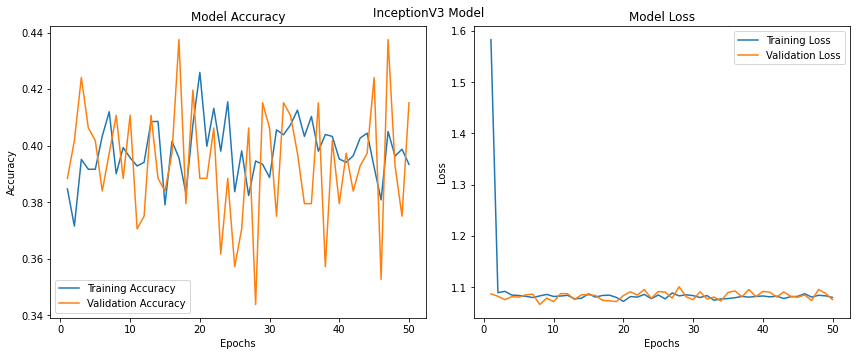

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(n, inceptionv3_with_aug_acc, label='Training Accuracy')
plt.plot(n, inceptionv3_with_aug_val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1,2,2)
plt.plot(n, inceptionv3_with_aug_loss, label='Training Loss')
plt.plot(n, inceptionv3_with_aug_val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.tight_layout()
plt.suptitle('InceptionV3 Model')
plt.savefig("plot_inceptionv3.png")
plt.show()

### Prediction of images using InceptionV3

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 15ms/step


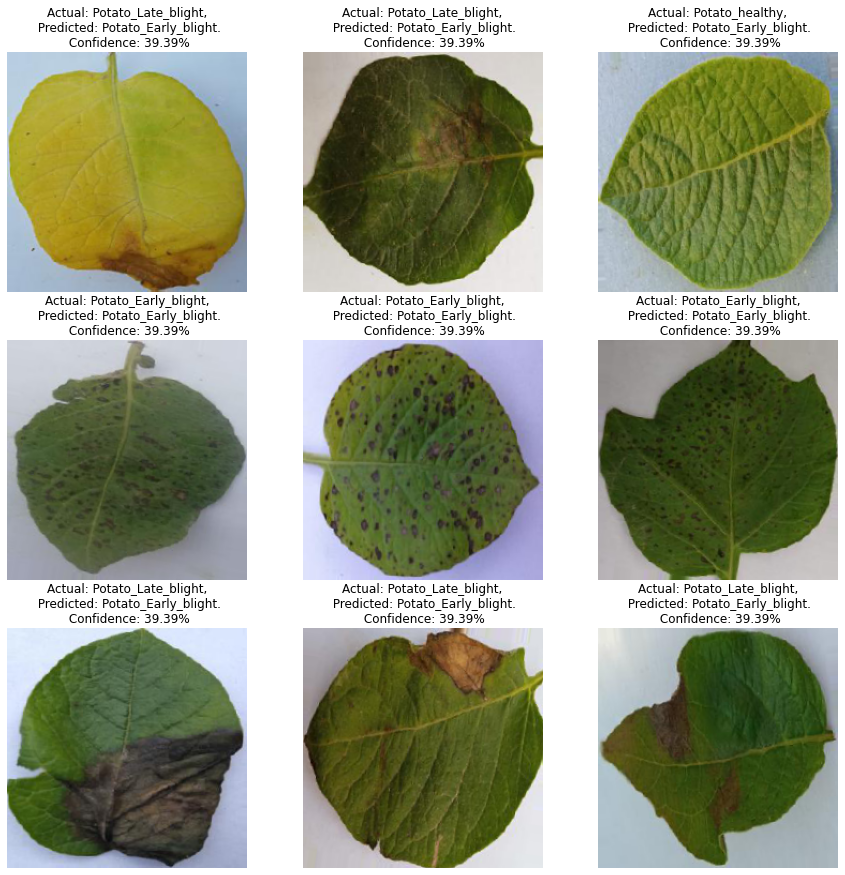

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(inceptionv3_with_aug_model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

plt.savefig("InceptionV3_prediction images")

### ResNet50

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

def create_model():
    model = models.Sequential()
    model.add(VGG19(include_top = False, weights = 'imagenet', input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation = 'relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(n_classes, activation='softmax'))
    
    return model

In [ ]:
resnet50_with_aug_model = create_model()
resnet50_with_aug_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_4   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                 771       
                                                      

### Compiling the model and determining the accuracy

In [ ]:
resnet50_with_aug_model.compile(
                            optimizer='adam',
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                            metrics=['accuracy'])

In [ ]:
resnet50_with_aug_history = resnet50_with_aug_model.fit(train_generator,
                                                   steps_per_epoch=54,
                                                   batch_size=32,
                                                   validation_data=validation_generator,
                                                    validation_steps = 7,
                                                    verbose=1,
                                                    epochs=EPOCHS)

Epoch 1/50
54/54 [==============================] - 33s 593ms/step - loss: 1.5126 - accuracy: 0.3736 - val_loss: 1.0890 - val_accuracy: 0.3705
Epoch 2/50
54/54 [==============================] - 32s 585ms/step - loss: 1.0846 - accuracy: 0.3999 - val_loss: 1.0897 - val_accuracy: 0.3929
Epoch 3/50
54/54 [==============================] - 32s 584ms/step - loss: 1.0908 - accuracy: 0.4033 - val_loss: 1.0782 - val_accuracy: 0.4509
Epoch 4/50
54/54 [==============================] - 32s 585ms/step - loss: 1.0812 - accuracy: 0.4073 - val_loss: 1.0938 - val_accuracy: 0.3884
Epoch 5/50
54/54 [==============================] - 32s 584ms/step - loss: 1.0794 - accuracy: 0.4073 - val_loss: 1.0891 - val_accuracy: 0.3750
Epoch 6/50
54/54 [==============================] - 32s 580ms/step - loss: 1.0820 - accuracy: 0.3953 - val_loss: 1.0645 - val_accuracy: 0.4330
Epoch 7/50
54/54 [==============================] - 32s 579ms/step - loss: 1.0827 - accuracy: 0.3835 - val_loss: 1.0834 - val_accuracy: 0.4152

### Producing the test accuracy and test loss

In [ ]:
resnet50_with_aug_scores = resnet50_with_aug_model.evaluate(test_generator)
resnet50_with_aug_test_acc = resnet50_with_aug_scores[1]*100
resnet50_with_aug_test_loss = resnet50_with_aug_scores[0]
print("Test Loss: ", resnet50_with_aug_test_loss) 
print("Test Accuracy: ", resnet50_with_aug_test_acc) 

13/13 [==============================] - 6s 434ms/step - loss: 1.0803 - accuracy: 0.4010
Test Loss:  1.0802948474884033
Test Accuracy:  40.09779989719391


### ResNet50 plot for accuracy vs loss

In [ ]:
resnet50_with_aug_history

In [ ]:
resnet50_with_aug_acc = resnet50_with_aug_history.history['accuracy']
resnet50_with_aug_val_acc = resnet50_with_aug_history.history['val_accuracy']

resnet50_with_aug_loss = resnet50_with_aug_history.history['loss']
resnet50_with_aug_val_loss = resnet50_with_aug_history.history['val_loss']

n = range(1, EPOCHS+1)

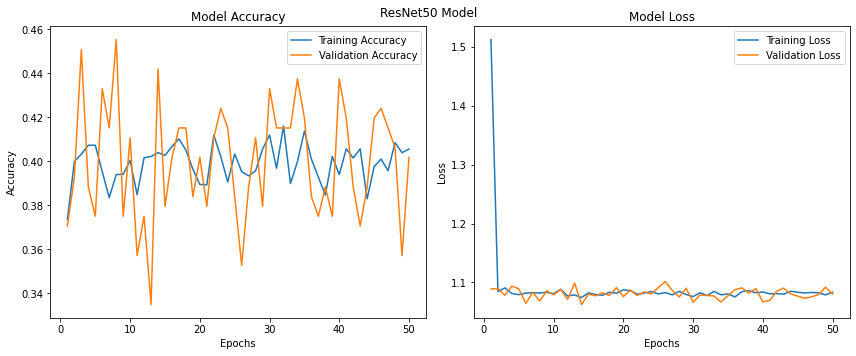

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(n, resnet50_with_aug_acc, label='Training Accuracy')
plt.plot(n, resnet50_with_aug_val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1,2,2)
plt.plot(n, resnet50_with_aug_loss, label='Training Loss')
plt.plot(n, resnet50_with_aug_val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.tight_layout()
plt.suptitle('ResNet50 Model')
plt.savefig("plot_resnet50.png")
plt.show()

### Prediction of images using ResNet50

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


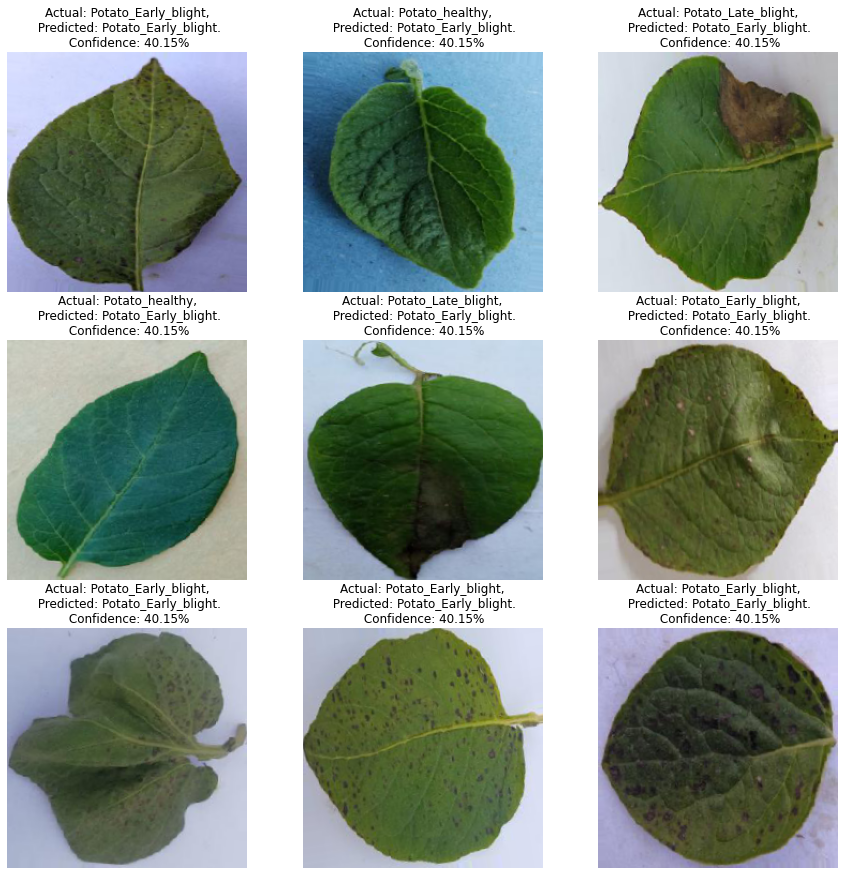

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(resnet50_with_aug_model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

plt.savefig("ResNet50V2_prediction images")

### Compare the transfer learning models performances

#### Comparing the test accuracies

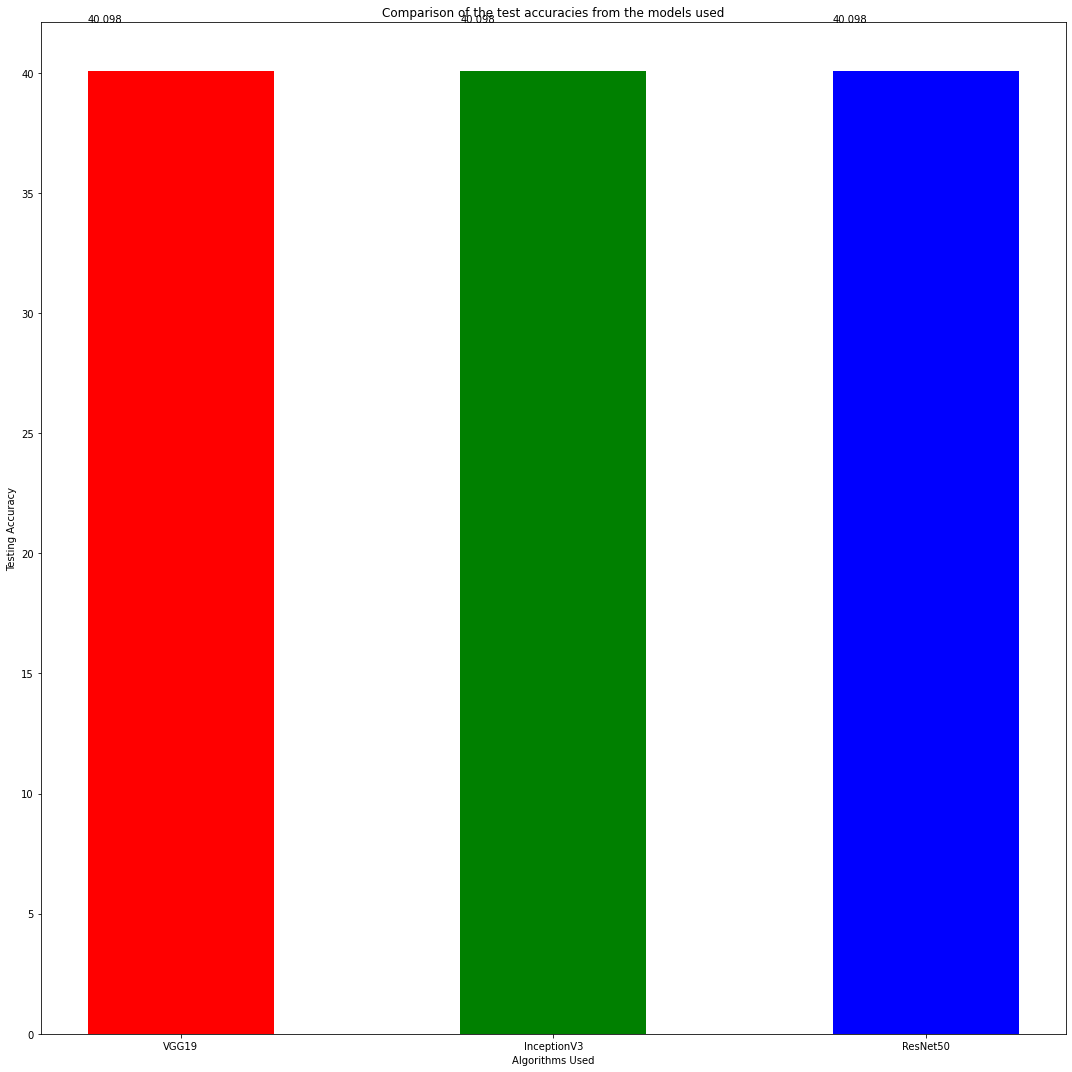

In [ ]:
algorithms = ['VGG19', 'InceptionV3', 'ResNet50']
accuracy = [vgg19_with_aug_test_acc, inceptionv3_with_aug_test_acc, resnet50_with_aug_test_acc]
accuracy = np.around([i for i in accuracy], 3)
colours = ['red', 'green', 'blue']

fig = plt.figure(figsize=(15,15))

# Plotting the bar chart
bars = plt.bar(algorithms, accuracy, color=colours, width = 0.5)

plt.xlabel("Algorithms Used")
plt.ylabel("Testing Accuracy")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval+2, yval)
    
plt.title('Comparison of the test accuracies from the models used')
plt.tight_layout()
plt.savefig('comparison_of_test_accuracies.png')
plt.show()

#### Comparing the test loss

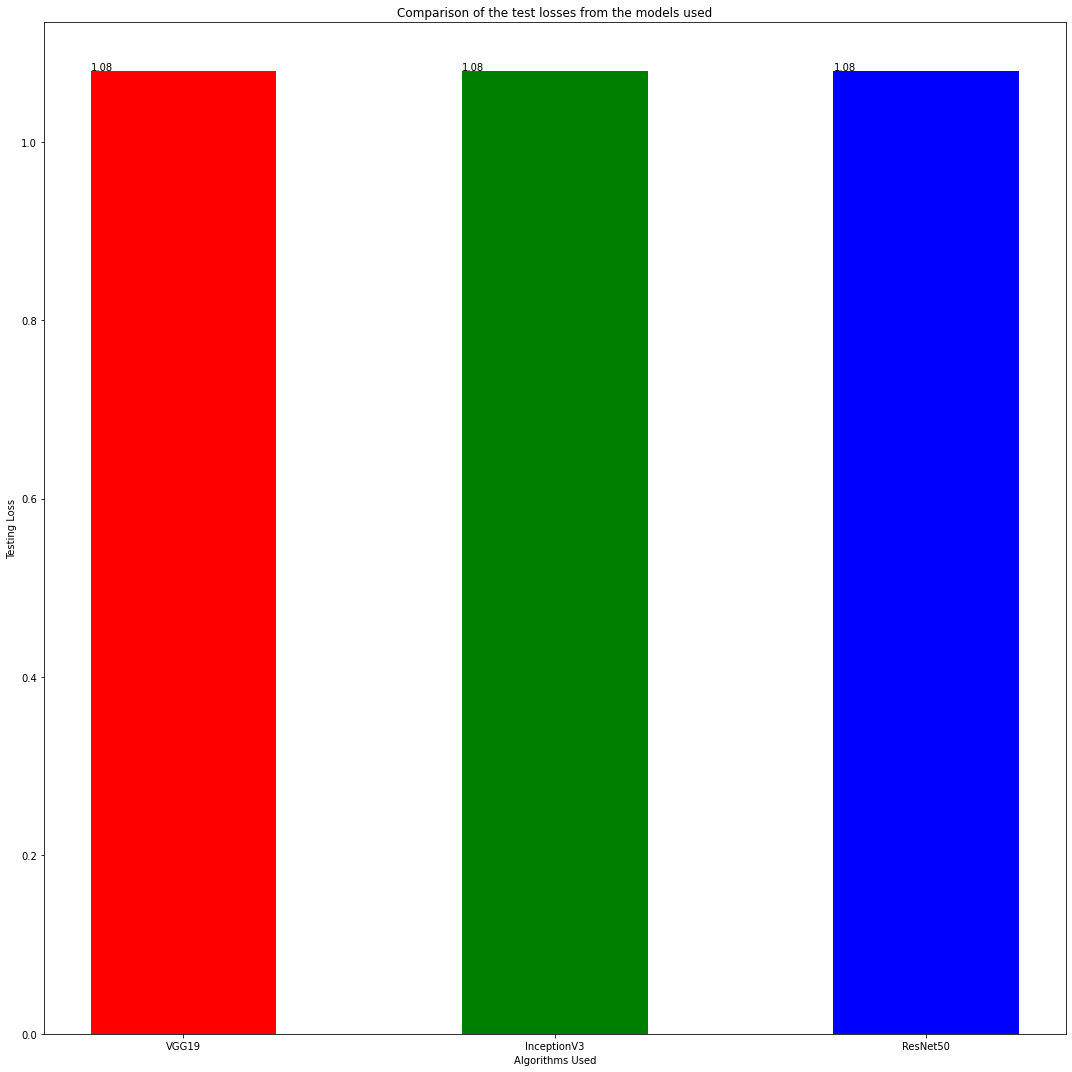

In [ ]:
algorithms = ['VGG19', 'InceptionV3', 'ResNet50']
loss = [vgg19_with_aug_test_loss, inceptionv3_with_aug_test_loss, resnet50_with_aug_test_loss]
loss = np.around([i for i in loss], 3)
colours = ['red', 'green', 'blue']

fig = plt.figure(figsize=(15,15))

# Plotting the bar chart
bars = plt.bar(algorithms, loss, color=colours, width = 0.5)

plt.xlabel("Algorithms Used")
plt.ylabel("Testing Loss")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval+0.00009, yval)
    
plt.title('Comparison of the test losses from the models used')
plt.tight_layout()
plt.savefig('comparison_of_test_losses.png')
plt.show()

In [ ]:
!jupyter nbconvert --to html PlantVillageTransferLearning.ipynb

[NbConvertApp] Converting notebook PlantVillageTransferLearning.ipynb to html
[NbConvertApp] Writing 5359748 bytes to PlantVillageTransferLearning.html
